In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import matplotlib
import numpy as np

In [2]:
matplotlib.style.use('ggplot')

In [3]:
aggregatedBinomial = pd.read_csv("../../../results/tables/aggregated_binomial.csv", index_col=0)
aggregatedBinomial = aggregatedBinomial[aggregatedBinomial["number_of_horserace_genes"]>200]

aggregatedBinomial["ratio_two_fold"] = (aggregatedBinomial["number_upregulated_genes_two_fold"] / aggregatedBinomial["number_of_two_fold_genes"]) * 100

aggregatedBinomial["ratio_horserace"] = (aggregatedBinomial["number_upregulated_genes_horserace"] / aggregatedBinomial["number_of_horserace_genes"]) * 100

In [4]:
normalityTest = pd.DataFrame()
for coupleName in aggregatedBinomial["couple"].unique():
    # Filter data
    data = pd.Series(aggregatedBinomial[aggregatedBinomial["couple"]==coupleName]["ratio_two_fold"])
    dataBootstraped = np.random.choice(data, size=300)

    statNormal, pvalNormal = stats.normaltest(dataBootstraped)
    statShapiro, pvalShapiro = stats.shapiro(dataBootstraped)
    tmpDict = {"pvalNormal": pvalNormal,
               "pvalShapiro": pvalShapiro,
               "couple": coupleName}
    normalityTest = normalityTest.append(tmpDict, ignore_index=True)
display(normalityTest.sort_values(by="pvalShapiro"))
display(normalityTest.loc[normalityTest["pvalShapiro"]>0.05])

couple    pvalNormal   pvalShapiro
9   12-14  9.820000e-12  9.929916e-09
1   13-16  3.707319e-05  2.808160e-08
6   01-07  1.727024e-04  1.280985e-07
5   02-15  1.125558e-06  6.008497e-07
10  02-07  4.187981e-02  1.128865e-06
4   03-11  2.324859e-04  1.618699e-06
8   04-12  3.009533e-03  1.521962e-05
2   08-15  6.827082e-05  3.042434e-04
3   09-17  7.548526e-02  3.069500e-03
7   06-14  7.134907e-02  7.033343e-03
0   05-10  7.731049e-01  3.410476e-02

Empty DataFrame
Columns: [couple, pvalNormal, pvalShapiro]
Index: []

In [5]:
normalCouples = normalityTest.loc[normalityTest["pvalShapiro"]<0.05]["couple"].to_list()

aggregatedBinomial = aggregatedBinomial[~aggregatedBinomial['couple'].isin(normalCouples)]
aggregatedBinomial

Empty DataFrame
Columns: [number_upregulated_genes_two_fold, number_of_two_fold_genes, pval_two_fold_rule, number_upregulated_genes_horserace, number_of_horserace_genes, pval_horse_race, couple, experience, ratio_two_fold, ratio_horserace]
Index: []

In [6]:
# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    distributionList = [
    stats.norm
    ]
    # Best holders
    bestDistribution = stats.norm
    bestDistributionParams = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in distributionList:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # identify if this distribution is better
                if best_sse > sse > 0:
                    bestDistribution = distribution
                    bestDistributionParams = params
                    best_sse = sse

        except Exception:
            pass

    return (bestDistribution.name, bestDistributionParams)

def make_probability_distribution_function(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get same start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [7]:



bestDistributionsDf = pd.DataFrame(columns=["couple", "size", "ks_stats", "ks_p_value", "dist_name", "dist_loc", "dist_scale"])

for coupleName in aggregatedBinomial["couple"].unique():
    # Filter data
    data = pd.Series(aggregatedBinomial[aggregatedBinomial["couple"]==coupleName]["ratio_two_fold"])
    dataBootstraped = np.random.choice(data, size=300)
    # Find best fit distribution
    bestFitName, bestFitParams = best_fit_distribution(dataBootstraped, 200)
    bestDist = getattr(stats, bestFitName)


    # Make PDF with best params 
    pdf = make_probability_distribution_function(bestDist, bestFitParams)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='Best fitted distribution', legend=True)
    dataBootstraped.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (bestDist.shapes + ', loc, scale').split(', ') if bestDist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, bestFitParams)])
    dist_str = '{}({})'.format(bestFitName, param_str)

    ax.set_title(u'Distribution of upregulated genes for couple: {}.\n with best distribution: {}'.format(coupleName, dist_str))
    ax.set_xlabel(u'Ratio')
    ax.set_ylabel('Frequency')


    stat, pval = stats.kstest(dataBootstraped, bestFitName, args=bestFitParams)

    tmpDict = {"couple": coupleName,
               "size": data.shape[0],
               "ks_stats": stat,
               "ks_p_value": pval,
               "dist_name":bestFitName,
               "dist_loc":bestFitParams[0],
               "dist_scale":bestFitParams[1]}
    bestDistributionsDf = bestDistributionsDf.append(tmpDict,ignore_index=True)

In [8]:
bestDistributionsDf

Empty DataFrame
Columns: [couple, size, ks_stats, ks_p_value, dist_name, dist_loc, dist_scale]
Index: []

In [9]:
def compute_ks(ksRow, aggregatedBinomial):
    # Generate distributions
    modeledDistribution = stats.norm.rvs(loc=50, size=ksRow["size"], scale=ksRow["dist_scale"])
    data = pd.Series(aggregatedBinomial[aggregatedBinomial["couple"]==ksRow["couple"]]["ratio_horserace"])
    # Compute Ks test
    stat, pVal = stats.ks_2samp(data, modeledDistribution)
    # https://en.wikipedia.org/wiki/Welch%27s_t-test
    statT, pValT = stats.ttest_ind(data, modeledDistribution, equal_var=False)
    statU, pValU =stats.mannwhitneyu(data, modeledDistribution, use_continuity=True, alternative=None)

    return {"pVal_ks":round(pVal,2),
            "pVal_T_Test_ind_equal_var":round(pValT,4),
            "pVal_U":round(pValU,4),
            
            "couple":ksRow["couple"],
            "real_dist_loc":round(ksRow["dist_loc"],2)}



tmpDict = bestDistributionsDf.apply(compute_ks, axis=1, args=(aggregatedBinomial,))

ksTestResults = pd.DataFrame(columns=["couple", "real_dist_loc"])
for i in tmpDict.to_list():
    ksTestResults = ksTestResults.append(i, ignore_index=True)

display(ksTestResults.sort_values(by="pVal_T_Test_ind_equal_var"))

bestDistributionsDf = bestDistributionsDf.merge(ksTestResults, on="couple")


# https://stats.stackexchange.com/questions/262708/comparison-of-distribution-mean-or-median

AttributeError: 'DataFrame' object has no attribute 'to_list'

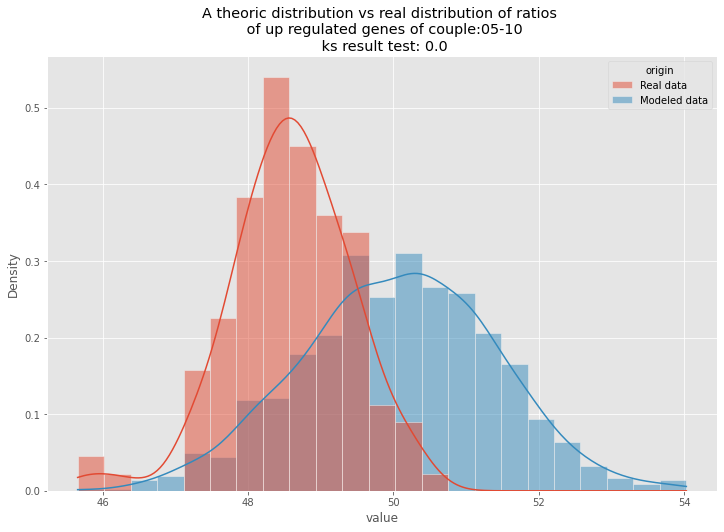

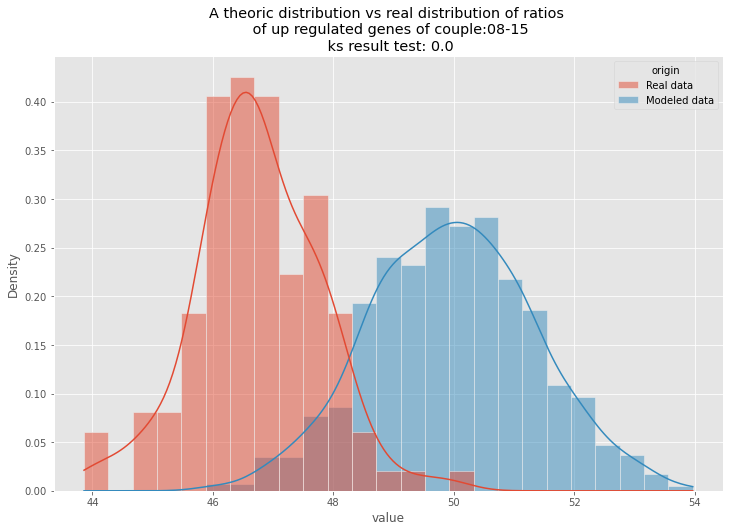

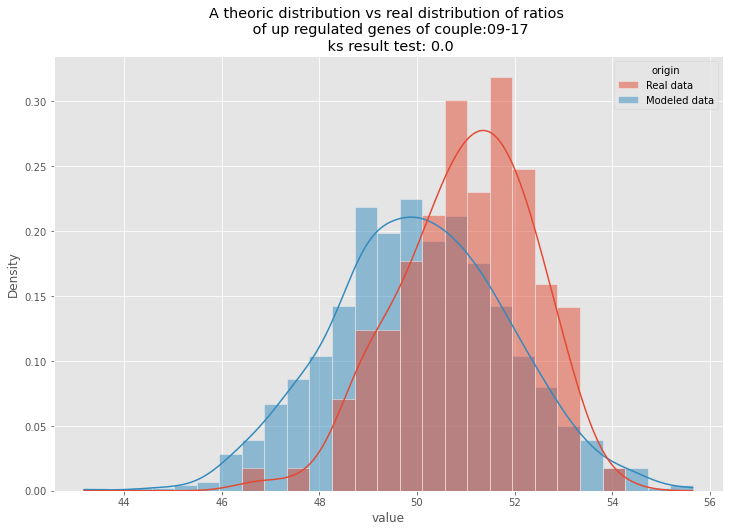

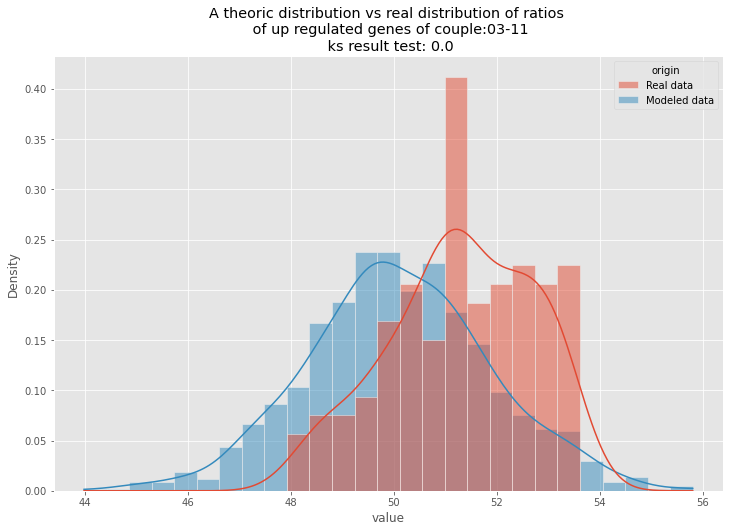

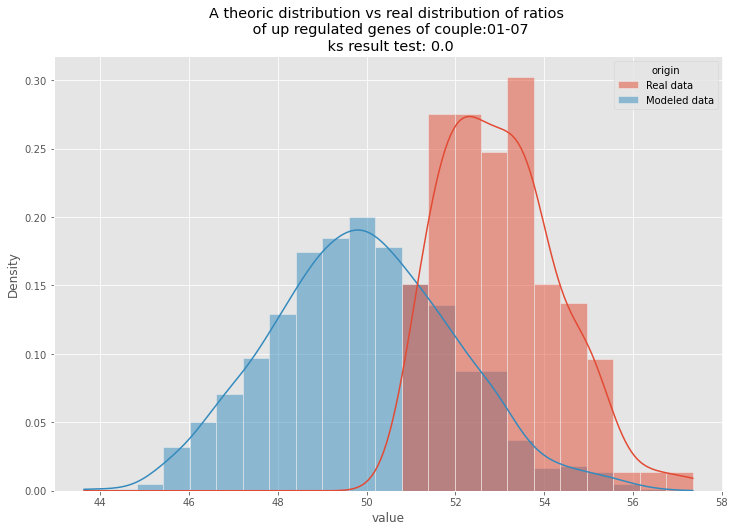

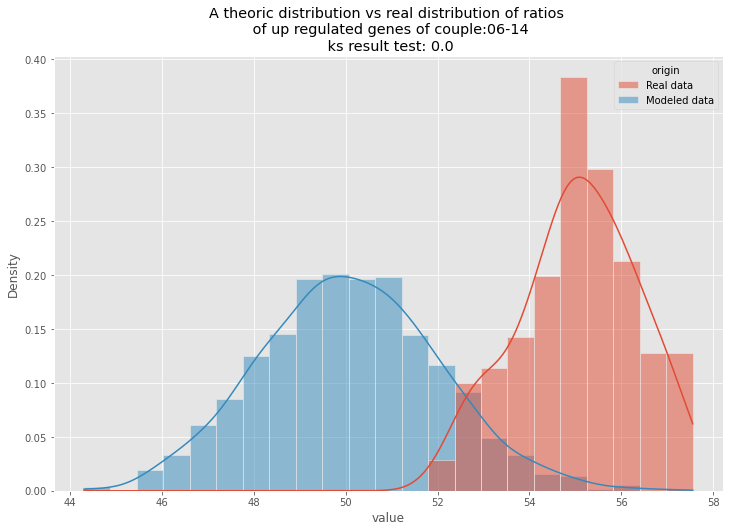

In [8]:
# https://www.hackdeploy.com/fitting-probability-distributions-with-python/

def visualize_distributions(ksRow, aggregatedBinomial):
    modeledDistribution = stats.norm.rvs(loc=50, size=1000, scale=ksRow["dist_scale"])
    data = pd.Series(aggregatedBinomial[aggregatedBinomial["couple"]==ksRow["couple"]]["ratio_horserace"])
    # Init a dataframe to construct graph
    distributionsToViz = pd.DataFrame(columns=["value", "origin"])
    distributionsToViz["value"] = data
    distributionsToViz["origin"] = "Real data"
    distributionsToViz1 = pd.DataFrame(columns=["value", "origin"])
    distributionsToViz1["value"] = modeledDistribution
    distributionsToViz1["origin"] = "Modeled data"
    distributionsToViz = distributionsToViz.append(distributionsToViz1)

    
    plt.figure(figsize=(12,8))
    title = "A theoric distribution vs real distribution of ratios \n of up regulated genes of couple:" + ksRow["couple"] + "\n ks result test: " + str(round(ksRow["pVal_ks"],4))

    sns.histplot(data=distributionsToViz, x="value", hue="origin", stat="density", kde=True, common_norm=False).set_title(title)
    plt.show()

useless = bestDistributionsDf.apply(visualize_distributions, axis=1, args=(aggregatedBinomial,))